In [1]:
import numpy as np
import sisl as si
import matplotlib.pyplot as plt

%matplotlib inline

# Anomalous Hall conductivity (AHC) for graphene

This tutorial will describe a complete walk-through of how to calculate the anomalous Hall conductivity for graphene.

## Creating the geometry to investigate

Our system of interest will be the pristine graphene system, from a DFT (SIESTA) calculation.

In [2]:
H = si.get_sile("siesta_2/RUN.fdf").read_hamiltonian()

The anomalous Hall conductivity (AHC) requires a rather dense $k$ grid. It is related to the Berry curvature defined as:
$$
    \boldsymbol\Omega_{i,\alpha\beta} = 2i\hbar^2\sum_{j\neq i}
                \frac{\hat v^{\alpha}_{ij} \hat v^\beta_{ji}}
                     {[\epsilon_j - \epsilon_i]^2 + i\eta^2}
$$
where $\hat v$ is the velocity operator. One can determine that the units of this quantity is $\mathrm{Ang}^2$.
The AHC can then be calculated via:
$$
    \sigma_{\alpha\beta} = \frac{-e^2}{\hbar}\int\,\mathrm d\mathbf k\sum_i f_i\Omega_{i,\alpha\beta}(\mathbf k).
$$
This method is implemented in `sisl.physics.electron.ahc`.
The units of AHC is $\mathrm S / \mathrm{Ang}^{2 - D}$ which for 2D systems is just $\mathrm S$.  
Its API looks like:

In [3]:
help(si.physics.electron.ahc)

Help on function ahc in module sisl.physics.electron:

ahc(bz: 'BrillouinZone', k_average: 'bool' = True, *, distribution: '_TDist' = 'step', eigenstate_kwargs={}, apply_kwargs={}, **berry_kwargs) -> 'np.ndarray'
    Electronic anomalous Hall conductivity for a given `BrillouinZone` integral

    .. math::
       \sigma_{\alpha\beta} = \frac{-e^2}{\hbar}\int\,\mathrm d\mathbf k\sum_i f_i\Omega_{i,\alpha\beta}(\mathbf k)

    where :math:`\Omega_{i,\alpha\beta}` and :math:`f_i` is the Berry curvature and occupation
    for state :math:`i`.

    The conductivity will be averaged by volume of the periodic unit cell.
    Hence the unit of `ahc` depends on the periodic unit cell.
    See `Lattice.volumef` for details.

    See :cite:`Wang2006` for details on the implementation.

    Parameters
    ----------
    bz : BrillouinZone
        containing the integration grid and has the ``bz.parent`` as an instance of Hamiltonian.
    k_average:
        if `True`, the returned quantity is averag

-----

We will be interested in calculating the `ahc` for a set of different energies (equivalent to different chemical potentials).
So we need to define an energy-range, and a distribution function, here the simple step-function is used.

In [4]:
E = np.linspace(-5, 2, 251)
# When calculating for a variety of energy-points, we have to have an available axis for the eigenvalue distribution
# calculation.
dist = si.get_distribution("step", x0=E.reshape(-1, 1))
# Generally you want a *very* dense k-point grid
bz = si.MonkhorstPack(H, [33, 33, 1], trs=False)

Since we are only interested in the $xy$ plane (there is no periodicity along $z$, hence superfluous calculation), we will try and reduce the computation by specifying which axes we want to calculate the AHC along.
Additionally, we can speed up the calculation for matrices that are small, by explicitly specifying them to be calculated in the `numpy.ndarray` format, as opposed to the default `scipy.sparse.csr_matrix` format (slower, but much less memory consuming).
When dealing with these conductivities it can also be instructive to view the $k$-resolved conductivities at certain energies.


Lastly, `eta=True` specifies we want to show the progressbar.



In [5]:
ahc = si.physics.electron.ahc(
    bz,
    # yield a k-resolved AHC array
    k_average=False,
    distribution=dist,
    # Speed up by format='array'
    eigenstate_kwargs={"format": "array", "dtype": np.complex128, "eta": True},
    # Speed up by only calculating the xx, xy, yx, yy contributions
    derivative_kwargs={"axes": "xy"},
).real  # we don't need the imaginary part.

MonkhorstPack.ndarray:   0%|          | 0/1089 [00:00<?, ?k/s]

Now we have a `(len(bz), 2, 2, len(E))` AHC array.

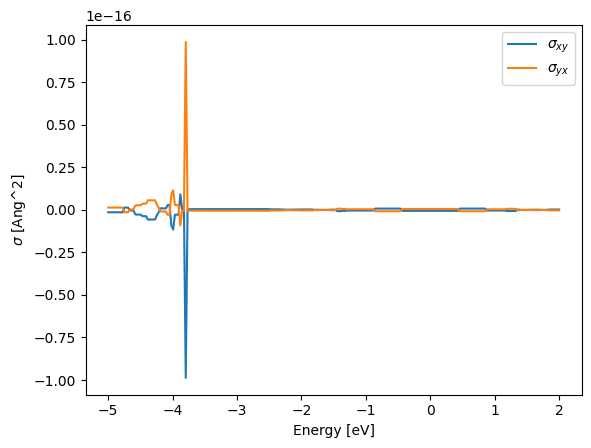

In [6]:
plt.plot(E, ahc.sum(0)[0, 1], label=r"$\sigma_{xy}$")
plt.plot(E, ahc.sum(0)[1, 0], label=r"$\sigma_{yx}$")
plt.xlabel("Energy [eV]")
plt.ylabel(r"$\sigma$ [Ang^2]")
plt.legend();

As we can see there are some contributions near $E_F$, and at the lower bands.  
The numbers though are not converged, and likely requires more scrutiny (outside the scope of this tutorial).

We can now plot the $k$-resolved AHC values at $E_F$:

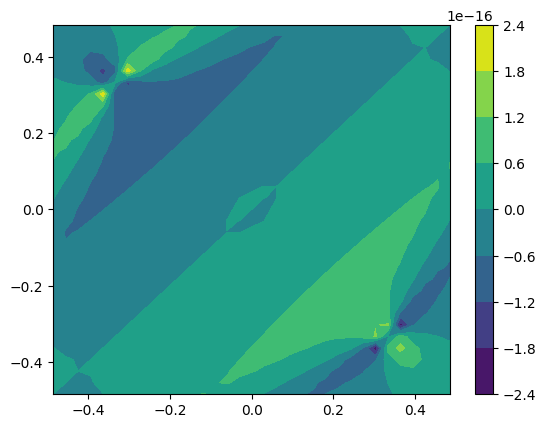

In [7]:
E0 = np.argmin(np.fabs(E))
kx = np.unique(bz.k[:, 0])
ky = np.unique(bz.k[:, 1])
plt.contourf(
    # unique values along x, y
    kx,
    ky,
    ahc[:, 0, 1, E0].reshape(len(kx), len(ky)),
)
plt.colorbar();

This concludes a simple tutorial on how to calculate the AHC for a given  system, and also how to calculate the $k$-resolved AHC.